In [1]:
''' Test data loading and other functions. '''
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from datafunc import applybulk
from plotting import comparison

### PSD

In [2]:
''' PSD - loading and processing. '''
ds = xr.load_dataset('../MLFLUXES/data/fluxes_all_cruises_compilation.nc')

# Remove nan
ds_psd = ds.dropna(dim="time", how="any", 
                   subset=['taucx','taucy','hsc','hlc','U','tsnk','ta','qa'])
print('Number of samples: %g' %(len(ds_psd.U.values)))

# Rename fields (dummy2 is relative humidity)
ds_psd = ds_psd.rename_vars({'tsnk':'tsea','ta':'tair','qa':'qair','dummy2':'rh'})
# Drop the not used variables
ds_psd = ds_psd[['taucx','taucy','hsc','hlc','U','tsea','tair','qair',
                 'rh', 'pcode','zu','zt','zq']]

# A few more adjustments that are data set specific 
ds_psd['qair'] = ds_psd['qair']/1000. # Make it into unit kg/kg
ds_psd['hsc'] = -ds_psd['hsc'] # Heat flux is positive when it's from air to ocean
ds_psd['hlc'] = -ds_psd['hlc']

# Compute bulk using COARE3.6 and then append to dataset
# Here when zq and zt are different height we use zt
ds_psd = applybulk(ds_psd, algo='coare3p6')

Number of samples: 10079


/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


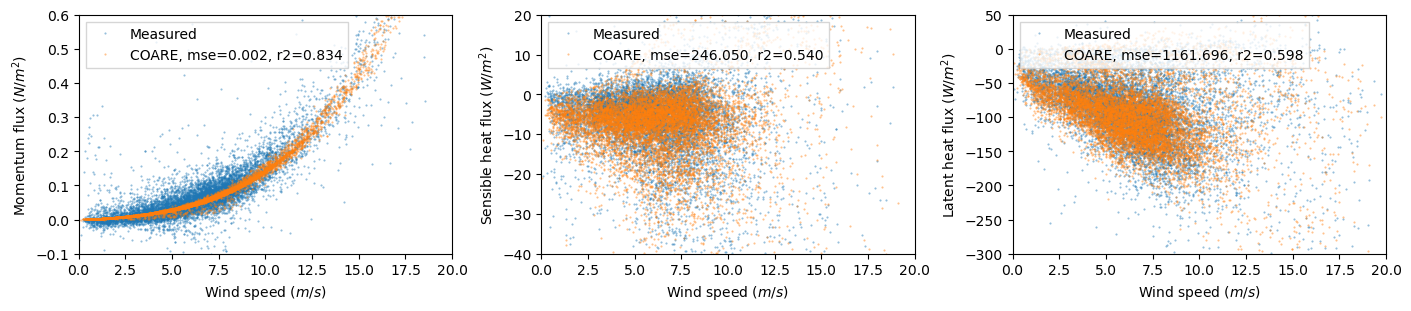

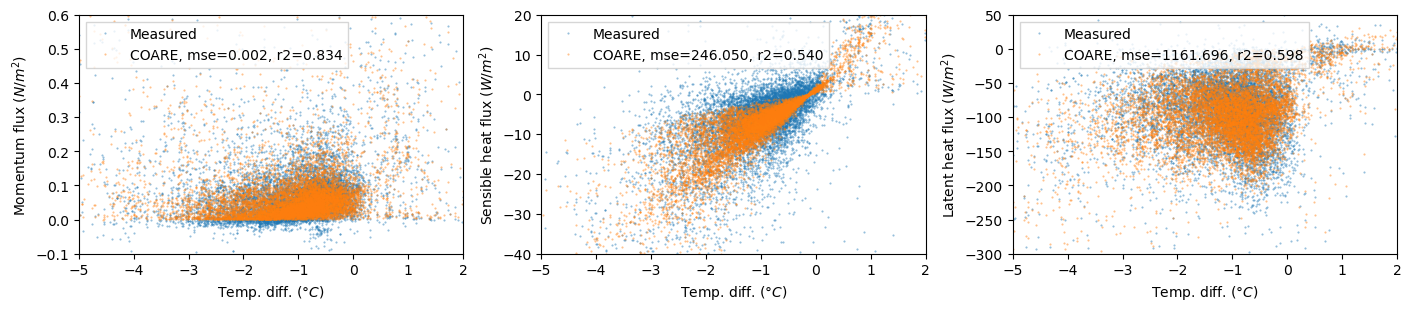

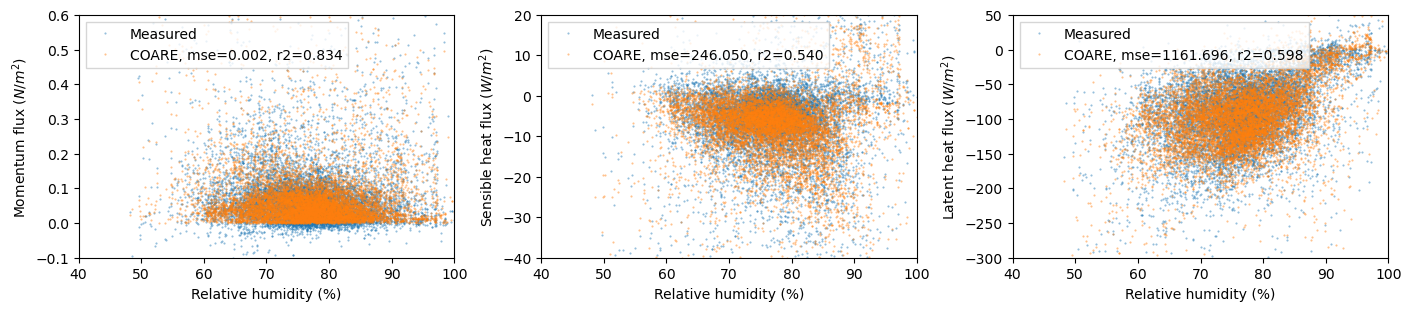

In [19]:
# Quick check that the bulk looks reasonable and signs agree
# Also evaluate how COARE is doing 

fig, axes = plt.subplots(1,3,figsize=[14,3],constrained_layout=True)
ax1 = comparison(ds_psd, axes[0], xplot='U', yplot='tau')
ax2 = comparison(ds_psd, axes[1], xplot='U', yplot='hs')
ax3 = comparison(ds_psd, axes[2], xplot='U', yplot='hl')

fig, axes = plt.subplots(1,3,figsize=[14,3],constrained_layout=True)
ax1 = comparison(ds_psd, axes[0], xplot='Tdiff', yplot='tau')
ax2 = comparison(ds_psd, axes[1], xplot='Tdiff', yplot='hs')
ax3 = comparison(ds_psd, axes[2], xplot='Tdiff', yplot='hl')

fig, axes = plt.subplots(1,3,figsize=[14,3],constrained_layout=True)
ax1 = comparison(ds_psd, axes[0], xplot='rh', yplot='tau')
ax2 = comparison(ds_psd, axes[1], xplot='rh', yplot='hs')
ax3 = comparison(ds_psd, axes[2], xplot='rh', yplot='hl')

Training samples: 7528
Validating samples: 879
Testing samples: 1666


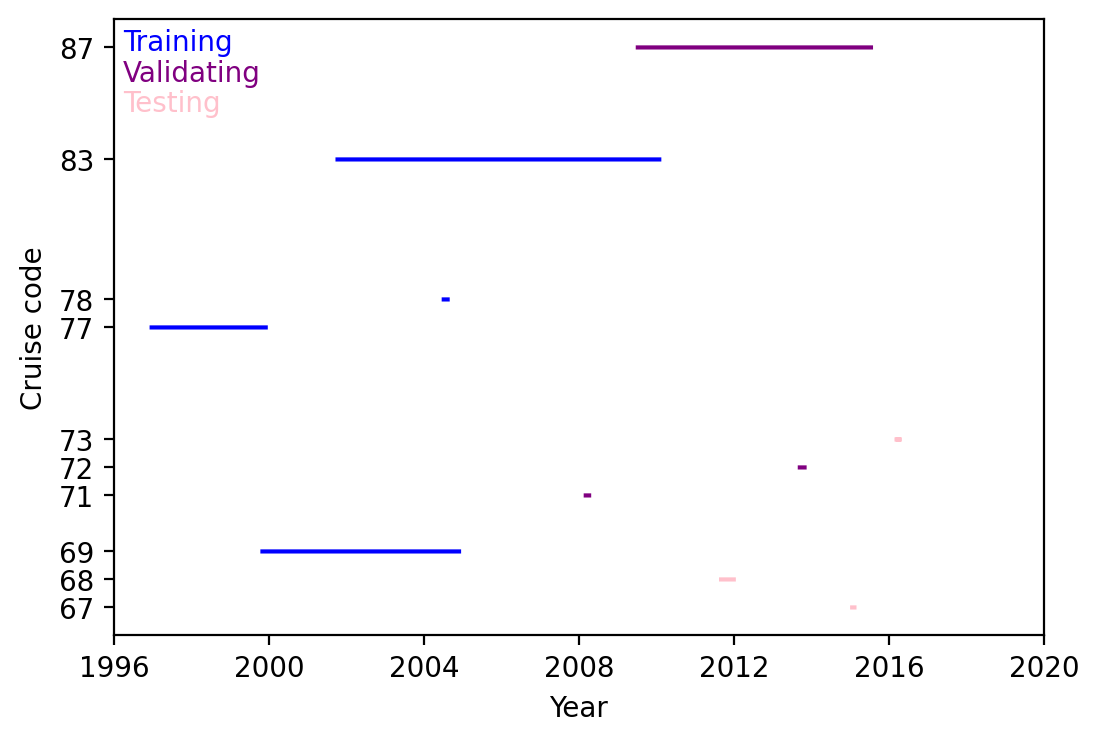

In [25]:
from datafunc import data_split_psd, assemble_var
train, valid, test = data_split_psd(ds_psd, split=[[77, 69, 83, 78], [87, 72, 71], [68, 67, 73]],
                                    PLOT=True, XVIS='time')
X_train, Y_train = assemble_var(train, choice='U_Tdiff_rh')
X_valid, Y_valid = assemble_var(valid, choice='U_Tdiff_rh')
X_test, Y_test = assemble_var(test, choice='U_Tdiff_rh')

### Atomic

In [14]:
''' Atomic - loading and processing '''
ds = xr.open_dataset('../MLFLUXES/data/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc')
ds_atomic = ds.dropna(dim="obs", how="any",
                      subset=["tau_streamwise_cov","tau_crossstream_cov",
                              "tau_bulk","hl_cov","hs_cov","wspd",'tsea','tair','qair'])
print('Number of samples: %g' %(len(ds_atomic.wspd.values)))

# Rename fields
ds_atomic = ds_atomic.rename_vars({'wspd':'U','tau_streamwise_cov':'taucx','tau_crossstream_cov':'taucy',
                                   'hl_cov':'hlc','hs_cov':'hsc','rhair':'rh'})

# A few more adjustments that are data set specific 
ds_atomic = ds_atomic.reset_coords('ztq')
ds_atomic = ds_atomic.reset_coords('zu')
ds_atomic = ds_atomic.rename_vars({'ztq':'zt'})
ds_atomic = ds_atomic.assign(zq=ds_atomic.zt) # zt and zq are the same for this one
ds_atomic['qair'] = ds_atomic['qair']/1000. # Make it into unit kg/kg

# # Drop the not used variables (for atomic zu and ztq are coordinates)
ds_atomic = ds_atomic[['taucx','taucy','hsc','hlc','U','tsea','tair','qair','rh','zu','zt','zq']]

# Compute bulk using COARE3.6 and then append to dataset
# Here zq and zt are the same height 
ds_atomic = applybulk(ds_atomic, algo='coare3p6')

Number of samples: 3285


/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


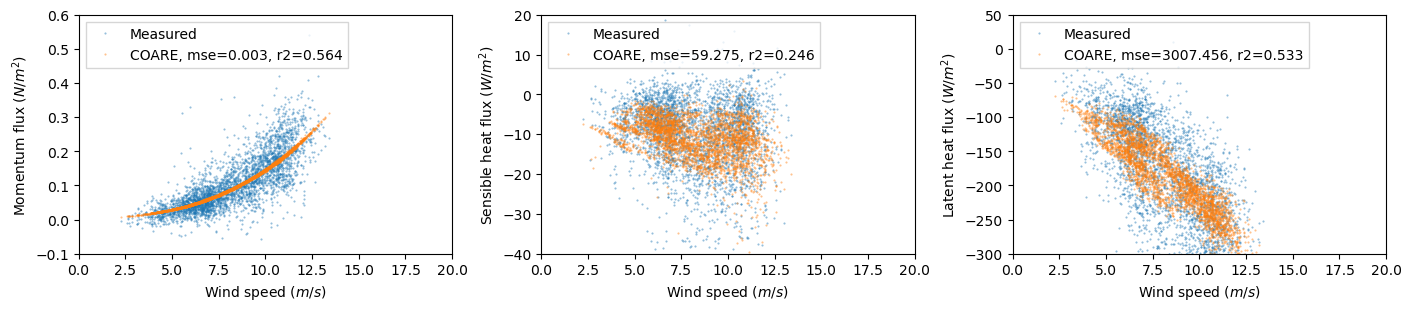

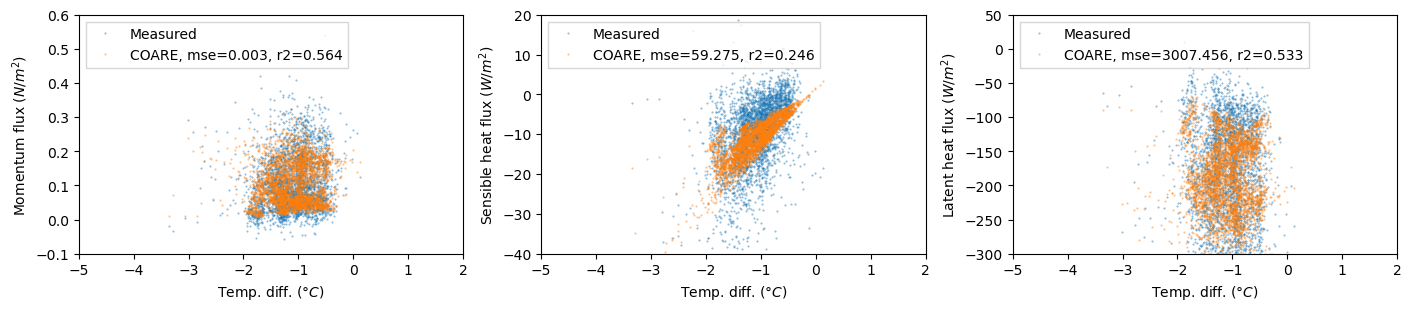

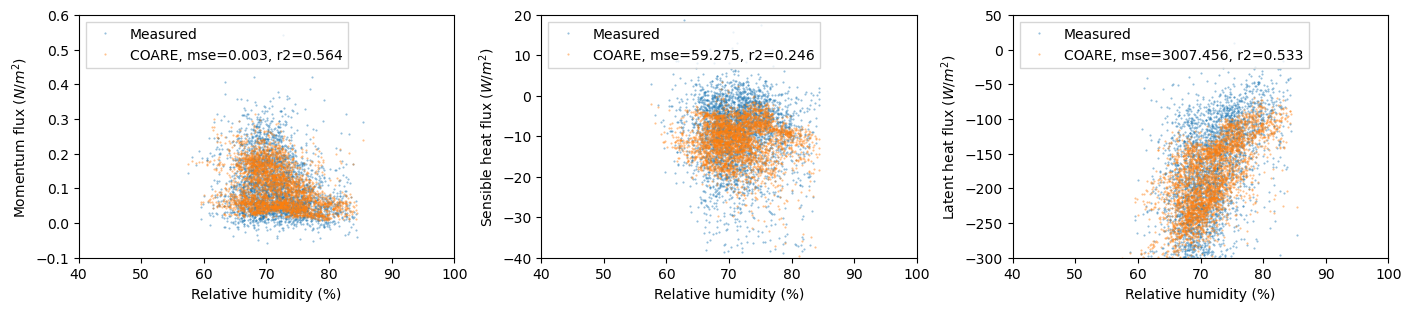

In [20]:
# Quick check that the bulk looks reasonable and signs agree
# Also evaluate how COARE is doing 

fig, axes = plt.subplots(1,3,figsize=[14,3],constrained_layout=True)
ax1 = comparison(ds_atomic, axes[0], xplot='U', yplot='tau')
ax2 = comparison(ds_atomic, axes[1], xplot='U', yplot='hs')
ax3 = comparison(ds_atomic, axes[2], xplot='U', yplot='hl')

fig, axes = plt.subplots(1,3,figsize=[14,3],constrained_layout=True)
ax1 = comparison(ds_atomic, axes[0], xplot='Tdiff', yplot='tau')
ax2 = comparison(ds_atomic, axes[1], xplot='Tdiff', yplot='hs')
ax3 = comparison(ds_atomic, axes[2], xplot='Tdiff', yplot='hl')

fig, axes = plt.subplots(1,3,figsize=[14,3],constrained_layout=True)
ax1 = comparison(ds_atomic, axes[0], xplot='rh', yplot='tau')
ax2 = comparison(ds_atomic, axes[1], xplot='rh', yplot='hs')
ax3 = comparison(ds_atomic, axes[2], xplot='rh', yplot='hl')

In [ ]:
@property

@classmethod